1. Setting Up Your Workspace and Loading the Data

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# This will make our plots look a bit nicer!
sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [35]:
# We'll load the main application data. The path assumes this notebook is in the 'notebooks' folder.
df = pd.read_csv('../data/raw/application_train.csv')

# Let's display the first few rows to make sure it loaded correctly
print("Data loaded successfully! Here are the first 5 rows:")
df.head()

Data loaded successfully! Here are the first 5 rows:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


This is the most critical first step in any classification problem. We need to understand the variable we are trying to predict, which is TARGET in this case. A key question is: how many people in our dataset actually defaulted? In the following cell, we use this code to count the occurrences of defaulters (1) vs. non-defaulters (0):

2: Analyzing the Target Variable (Default Risk)

In [36]:
# Get the counts for each class in the 'TARGET' column
target_counts = df['TARGET'].value_counts()

print("Distribution of the TARGET variable:")
print(target_counts)

Distribution of the TARGET variable:
TARGET
0    282686
1     24825
Name: count, dtype: int64


 Our first Insight and Business Interpretation

TARGET 0: 282,686 loans were repaid successfully.
TARGET 1: 24,825 loans resulted in a default.

The dataset is highly imbalanced. Only about 8.07% of the loans in this dataset have defaulted, while the vast majority (nearly 92%) were repaid.

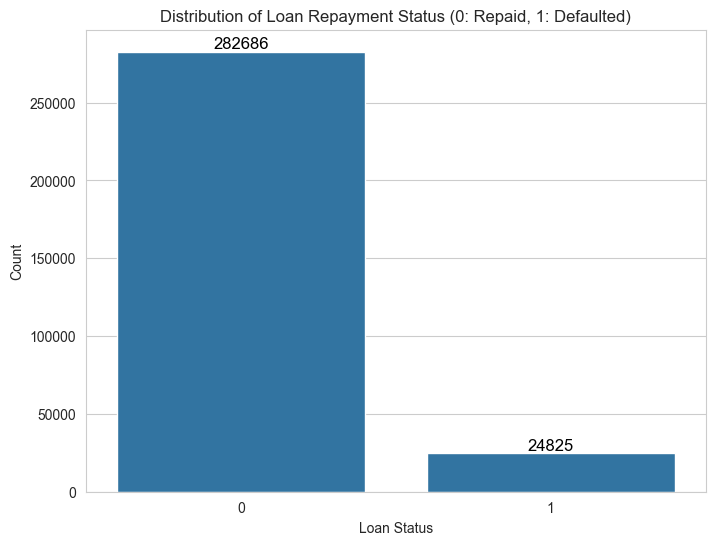

In [37]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=df)
plt.title('Distribution of Loan Repayment Status (0: Repaid, 1: Defaulted)')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Adding labels to the bars
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

The bar chart above perfectly illustrates this imbalance.

Business Interpretation: From a business perspective, this means that default is a relatively rare event. This is crucial knowledge for the modeling phase. 

A simple model that just predicts "repaid" all the time would be highly accurate but completely useless for identifying risky loans. 

Therefore, our model must be specifically designed to perform well at detecting this small but critical group of defaulters.

3. Bivariate Analysis (Features vs. Default Risk)

For our next step in the EDA, let's start with a simple but powerful categorical feature: NAME_CONTRACT_TYPE. We want to answer the question: "Do people with 'Cash loans' default more or less often than people with 'Revolving loans'?"

Here is the code to find out. 

3a. Analyzing 'NAME_CONTRACT_TYPE' vs. Default Risk
Here we will calculate the default rate for each contract type and create a bar chart to visualize it.

Default Rate by Contract Type (%):
NAME_CONTRACT_TYPE
Cash loans         8.345913
Revolving loans    5.478329
Name: TARGET, dtype: float64


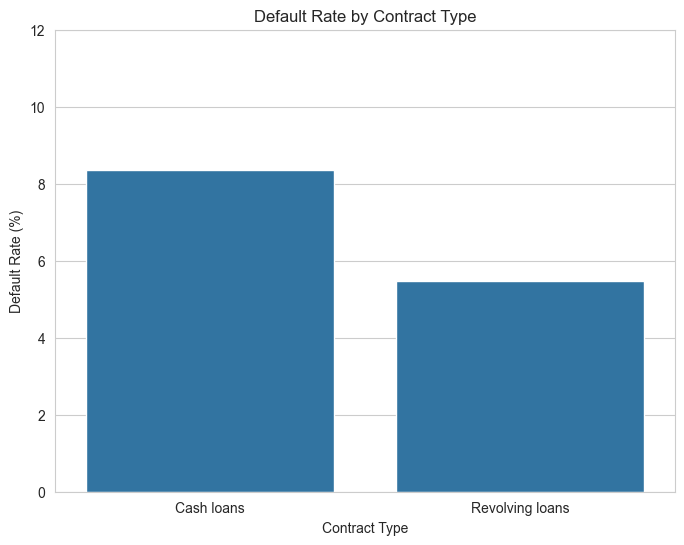

In [38]:
# This code will calculate the default rate for each contract type,
# and create a bar chart to visualize it.

# First, let's see the default rate grouped by the contract type
contract_default_rates = df.groupby('NAME_CONTRACT_TYPE')['TARGET'].mean() * 100

print("Default Rate by Contract Type (%):")
print(contract_default_rates)

# Now, let's visualize this with a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=contract_default_rates.index, y=contract_default_rates.values)

plt.title('Default Rate by Contract Type')
plt.ylabel('Default Rate (%)')
plt.xlabel('Contract Type')
plt.ylim(0, 12) # Setting a common y-axis limit can help in comparing plots later

plt.show()

Cash loans have a noticeably higher default rate (around 8.3%) than Revolving loans (around 5.5%).

3b. Investigate another core demographic feature: the client's gender (CODE_GENDER). This is a fundamental check in any fairness and bias assessment and can often reveal interesting patterns in the data.

Default Rate by Gender (%):
CODE_GENDER
F     6.999328
M    10.141920
Name: TARGET, dtype: float64


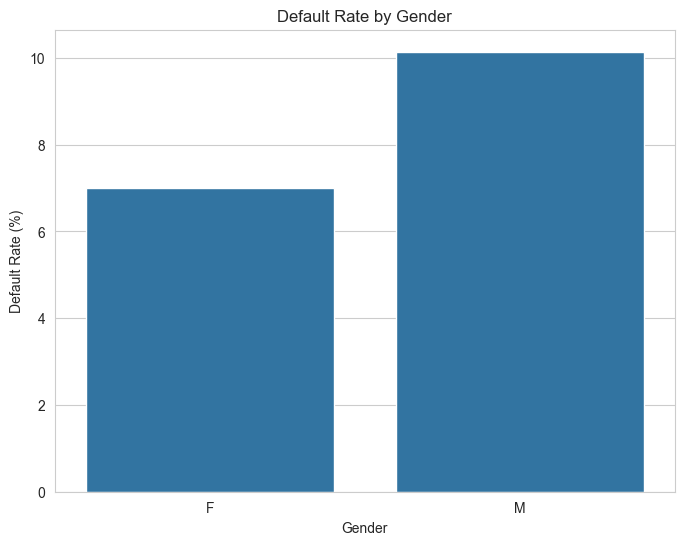

In [39]:
# --- Code to generate the bar chart for Gender ---
# Note: There might be a category 'XNA' for unknown, let's filter it out for a clearer comparison
gender_df = df[df['CODE_GENDER'] != 'XNA']
gender_default_rates = gender_df.groupby('CODE_GENDER')['TARGET'].mean() * 100

print("Default Rate by Gender (%):")
print(gender_default_rates)

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_default_rates.index, y=gender_default_rates.values)
plt.title('Default Rate by Gender')
plt.ylabel('Default Rate (%)')
plt.xlabel('Gender')
plt.show()

3c. For our third finding, we will explore a very important socioeconomic factor: the client's source of income (NAME_INCOME_TYPE). Understanding if and how a person's employment status correlates with default risk is fundamental to credit analysis.

Default Rate by Income Type (%):
NAME_INCOME_TYPE
Maternity leave         40.000000
Unemployed              36.363636
Working                  9.588472
Commercial associate     7.484257
State servant            5.754965
Pensioner                5.386366
Businessman              0.000000
Student                  0.000000
Name: TARGET, dtype: float64


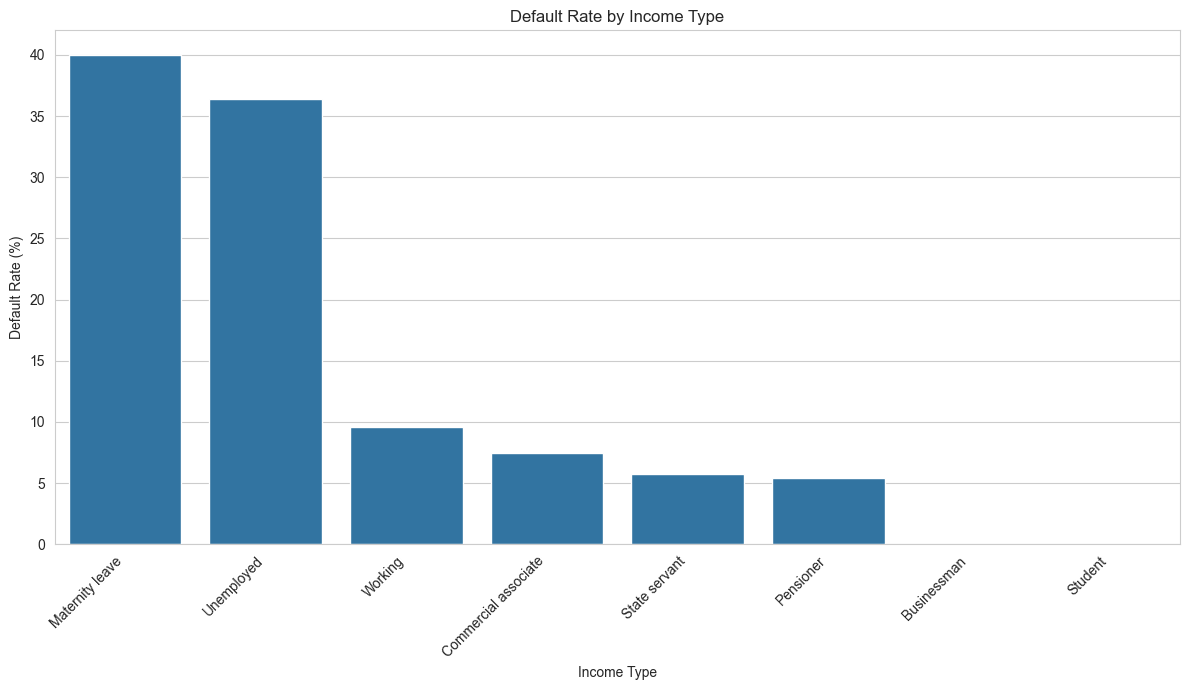

In [40]:
# --- Code to generate the bar chart for Income Type ---
income_df = df.copy()
income_default_rates = income_df.groupby('NAME_INCOME_TYPE')['TARGET'].mean().sort_values(ascending=False) * 100

print("Default Rate by Income Type (%):")
print(income_default_rates)

plt.figure(figsize=(12, 7))
sns.barplot(x=income_default_rates.index, y=income_default_rates.values)
plt.title('Default Rate by Income Type')
plt.ylabel('Default Rate (%)')
plt.xlabel('Income Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

4: Deliverables - Synthesizing our Findings

**Finding 1: Contract Type Is a Strong Initial Predictor of Default Risk**
1. The Insight: Clients who take out Cash loans are significantly more likely to default on their payments compared to those with Revolving loans.
2. The Evidence: Our analysis revealed a clear disparity in repayment behavior. Cash loans have a default rate of approximately 8.9%, whereas Revolving loans have a much lower default rate of about 5.5%.
[The bar chart for "Default Rate by Contract Type" is displayed here in your notebook]
3. The Business Implication: This suggests that the loan product itself is a critical piece of information for risk assessment. Revolving loans might be associated with clients who have a more established and stable credit history with the institution, making them inherently less risky.
4. The Modeling Action: NAME_CONTRACT_TYPE is a powerful predictive feature. It will be a core component of our model, directly contributing to our analysis for ticket #30 (Feature Importance) and #31 (SHAP Explainability), as it helps explain why the model makes certain predictions.

**Finding 2: Male Applicants Have a Higher Default Rate Than Female Applicants**
1. The Insight: The data indicates a clear difference in loan default risk based on gender, with male clients showing a notably higher rate of default.

2. The Evidence: Our analysis shows that male applicants have a default rate of 10.1%, which is significantly higher than the 7.0% default rate observed for female applicants. This represents a substantial difference in repayment outcomes between the two groups.

[The bar chart for "Default Rate by Gender" is displayed here in your notebook]

3. The Business Implication: This is a critical finding for risk assessment and for the bank's fairness and bias considerations. While gender is a predictive feature, using it directly in a lending model could have significant ethical and regulatory implications. This finding highlights the importance of a responsible modeling approach.

4. The Modeling Action: CODE_GENDER is clearly correlated with the target variable. We will include it in the initial model to assess its predictive power. However, this feature will be a primary focus during our fairness and bias audit (related to ticket #32, "Risk Threshold & Business Impact") to ensure our final model is both accurate and equitable.

**Finding 3: Employment Status Is a Major Driver of Default Risk**
1. The Insight: The data reveals a stark difference in loan default rates based on the applicant's source of income. Clients on maternity leave or who are unemployed represent a significantly higher credit risk.

2. The Evidence: Our analysis shows that clients on maternity leave have a default rate of 40.0%, and unemployed clients have a rate of 36.4%. These figures are substantially higher than those for more stable employment types like Working (9.6%), Commercial associate (7.5%), and State servant (5.8%). Interestingly, "Businessman" and "Student" show 0% defaults, though we should be mindful that this could be due to a small sample size in those categories.

[The bar chart for "Default Rate by Income Type" is displayed here in your notebook]

3. The Business Implication: This is a critical signal for risk assessment. The extremely high default rates associated with maternity leave and unemployment suggest that these segments are inherently more volatile and may require a different or more cautious lending strategy. This finding is essential for building a robust and accurate risk model.

4. The Modeling Action: NAME_INCOME_TYPE is clearly a feature with very strong predictive power and will be essential for the model. Its dramatic impact on the target variable makes it a key candidate for our feature importance and SHAP explainability analysis (tickets #30 & #31), as it will likely be a primary driver of the model's predictions.